# Query-by-committee

In [363]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from tqdm.notebook import tqdm
from collections import namedtuple
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling, consensus_entropy_sampling, max_disagreement_sampling
from skorch import NeuralNetClassifier
from torchvision import datasets
from joblib import Parallel, delayed
from modAL.models.base import BaseCommittee
from modAL.utils.data import modALinput

DEFAULT_SEED = 43
np.random.seed(DEFAULT_SEED)
torch.manual_seed(DEFAULT_SEED)
torch.cuda.manual_seed(DEFAULT_SEED)

sns.set_theme(style="darkgrid")
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

In [364]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.fc(self.conv(x))

In [365]:
def create_learner(X_training, y_training, max_epochs=8, module__num_classes=3):
    random_lr = 0.001 * (0.5 + np.random.rand())
    random_dropout = 0.3 + 0.4 * np.random.rand()
    net = NeuralNetClassifier(
        SimpleCNN,
        max_epochs=max_epochs,
        lr=random_lr,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        device=device,
        train_split=None,
        verbose=0,
        iterator_train__shuffle=True,
        module__num_classes=module__num_classes,
        batch_size=32,
        module__dropout_rate=random_dropout,
    )
    return ActiveLearner(
        estimator=net,
        X_training=X_training,
        y_training=y_training,
    )

In [366]:
def load_filtered_CIFAR(
    selected_labels, num_train_per_class=200, num_test_per_class=100
):
    train = datasets.CIFAR100(root="./data", train=True, download=True)
    test = datasets.CIFAR100(root="./data", train=False, download=True)

    def filter_data(X, y, n):
        filtered_images = []
        filtered_labels = []

        for i, label in enumerate(selected_labels):
            indices = np.where(y == label)[0][:n]
            filtered_images.append(X[indices])
            filtered_labels.append(np.full(len(indices), i))

        X_filtered = np.concatenate(filtered_images, axis=0).astype(np.float32) / 255.0
        y_filtered = np.concatenate(filtered_labels, axis=0).astype(np.int64)

        # Reshape to (N, C, H, W) format
        X_filtered = X_filtered.transpose(0, 3, 1, 2)

        return X_filtered, y_filtered

    X_train, y_train = filter_data(
        train.data, np.array(train.targets), num_train_per_class
    )
    X_test, y_test = filter_data(test.data, np.array(test.targets), num_test_per_class)

    return X_train, y_train, X_test, y_test

In [367]:
def evaluate_model(committee, X_test, y_test):
    with torch.no_grad():
        return np.mean(committee.predict(X_test) == y_test)

def run_active_learning(
    i,
    method,
    committee_size,
    X_train,
    y_train,
    X_test,
    y_test,
    n_initial,
    n_queries,
    query_batch_size,
):
    method_name, method_func = method

    method_hash = sum(ord(c) for c in method_name) % 10000
    seed = DEFAULT_SEED + (i * 10000) + method_hash
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    unique_classes = np.unique(y_train)
    def get_initial_samples():
        n_classes = len(unique_classes)
        samples_per_class = n_initial // n_classes
        remainder = n_initial % n_classes
        initial_indices = []
        for class_idx, class_label in enumerate(unique_classes):
            class_samples = np.where(y_train == class_label)[0]
            n_samples = samples_per_class + (1 if class_idx < remainder else 0)
            selected_indices = np.random.choice(class_samples, size=n_samples, replace=False)
            initial_indices.extend(selected_indices)
        return np.array(initial_indices)
    
    initial_indices = get_initial_samples()
    np.random.shuffle(initial_indices)
    X_init, y_init = X_train[initial_indices], y_train[initial_indices]

    if len(np.unique(y_init)) != len(unique_classes):
        print("Did not found enough classes - resampling", y_init)
        initial_indices = get_initial_samples()
        np.random.shuffle(initial_indices)
        X_init, y_init = X_train[initial_indices], y_train[initial_indices]

    committee_members = [create_learner(X_init, y_init) for _ in range(committee_size)]
    committee = Committee(committee_members, method_func)

    available_mask = np.ones(len(X_train), dtype=bool)
    available_mask[initial_indices] = False

    history = [None] * n_queries

    with torch.no_grad():
        accuracy = np.mean(committee.predict(X_test) == y_test)

    history[0] = ResultsRecord(method_name, 0, accuracy)

    desc = f'Run {i} with {method_name}'
    for idx in (pbar := tqdm(range(1, n_queries), desc=desc)):
        available_indices = np.where(available_mask)[0]

        pool_query_idx, _ = committee.query(X_train[available_indices], n_instances=query_batch_size)

        original_indices = available_indices[pool_query_idx]

        committee.teach(X_train[original_indices], y_train[original_indices])

        with torch.no_grad():
            accuracy = np.mean(committee.predict(X_test) == y_test)

        history[idx] = ResultsRecord(method_name, idx, accuracy)

        pbar.set_description(f"Method: {method_name}, Query {idx}, Accuracy: {accuracy:.4f}")
        # score = committee.score(X_test, y_test)

        # history[idx] = ResultsRecord(method_name, idx, score)


        available_mask[original_indices] = False

    return history

In [368]:
def random_sampling(committee: BaseCommittee, X: modALinput,
                          n_instances: int = 1, random_tie_break=False,
                          **disagreement_measure_kwargs):
    return np.random.choice(len(X), n_instances), np.zeros(n_instances)

In [369]:
# Experiments
selected_labels = [1, 3, 4]
n_classes = len(selected_labels)
n_initials = 3 * n_classes
n_queries = 100
committee_size = 8
n_repeats = 10
query_batch_size = 4
num_train_per_class = 200
num_test_per_class = 150
disagreement_methods = {
    "Vote entropy": vote_entropy_sampling, 
    "Consensus entropy": consensus_entropy_sampling, 
    "Kullback-Liebler divergence": max_disagreement_sampling,
    "Random sampling": random_sampling
}
run_parallel = True

X_train, y_train, X_test, y_test = load_filtered_CIFAR(selected_labels, num_train_per_class, num_test_per_class)

Files already downloaded and verified
Files already downloaded and verified


In [370]:
combinations = it.product(range(n_repeats), disagreement_methods.items())
num_samples = n_repeats * len(disagreement_methods)

def run_sample(i, method):
    return run_active_learning(i, method, committee_size, X_train, y_train, X_test, y_test, n_initials, n_queries, query_batch_size)

if run_parallel:
    results = [r for r in tqdm(Parallel(return_as="generator", n_jobs=min(num_samples, 8))(delayed(run_sample)(i, method)
                    for i, method in combinations), total=num_samples)]
else:   
    results = [run_sample(i, method) for i, method in tqdm(combinations, total=num_samples)]

committee_results = [r for rs in results for r in rs]

  0%|          | 0/40 [00:00<?, ?it/s]

In [371]:
df_results = pd.DataFrame(committee_results)
df_results.to_csv("data.csv", index=False)
df_results["estimator"].unique()

array(['Vote entropy', 'Consensus entropy', 'Kullback-Liebler divergence',
       'Random sampling'], dtype=object)

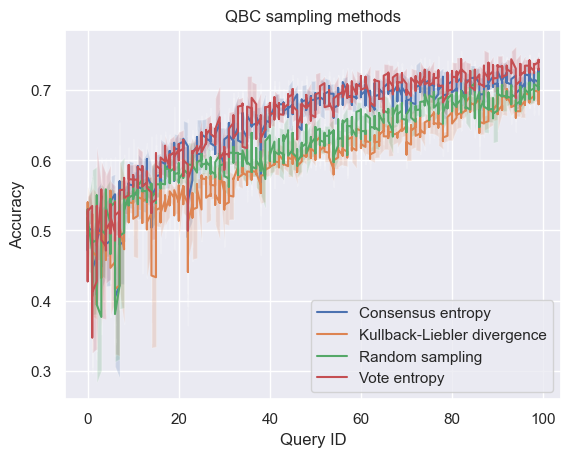

In [372]:
df_results = pd.read_csv("data.csv")
fig, ax = plt.subplots()
rolling = min(n_queries, 4)
for est, grp in df_results.groupby("estimator"):
    grp = grp.sort_values("query_id")
    mean = grp["score"].rolling(rolling).mean()
    std = grp["score"].rolling(rolling).std()
    ax.plot(grp["query_id"], mean, label=est)
    ax.fill_between(grp["query_id"], mean - std, mean + std, alpha=0.2)
ax.set_xlabel("Query ID")
ax.set_ylabel("Accuracy")
ax.set_title("QBC sampling methods")
ax.legend()
plt.savefig("experiment.png")
plt.show()

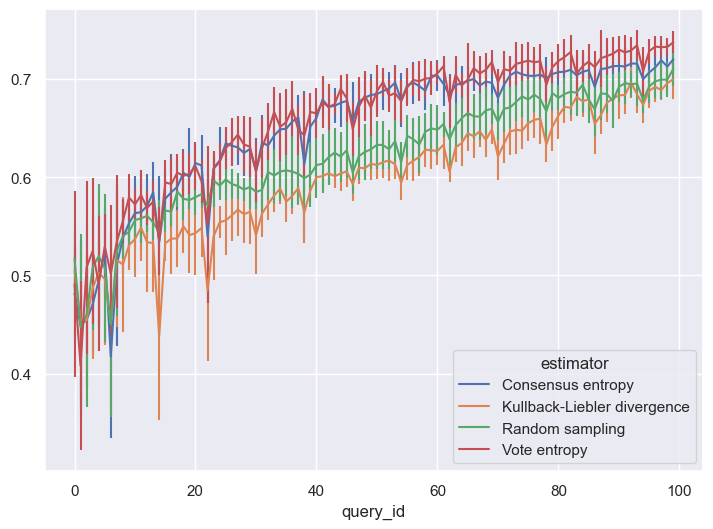

In [373]:
df_results_mean=df_results.groupby(['estimator','query_id']).mean()
df_results_std=df_results.groupby(['estimator','query_id']).std()

df_mean=df_results_mean.reset_index().pivot(index='query_id', columns='estimator', values='score')
df_std=df_results_std.reset_index().pivot(index='query_id', columns='estimator', values='score')

df_mean.plot(figsize=(8.5,6), yerr=df_std)
plt.grid('on')